# Import Packages

In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import OrderedDict

# Load the Data

In [60]:
# Load training data
train_df = pd.read_csv("./train.csv")
print("Train shape : ", train_df.shape)
train_df.head()

Train shape :  (925142, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


# Display rows with NaN values

In [61]:
nan_rows = train_df[train_df.isna().any(axis=1)]
print(nan_rows)

                         qid                         question_text  target
925141  b54e97aa528c52f56aba  What is meant by surface maping of b     NaN


# Remove rows with NaN values

In [62]:
train_df = train_df.dropna()
print("Train shape : ", train_df.shape)
train_df.head()

Train shape :  (925141, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0.0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0.0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0.0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0.0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0.0


# Split the data into training and validation sets

In [63]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2018)

In [64]:
val_df.head()

,qid,question_text,target
117160,16ed5db88237badb1353,What courses are better between these two: UCS...,0.0
557957,6d5300c9b4788379b00b,Is Hunter x Hunter worth my time?,0.0
17048,0357fdaa4d764e8a40c5,Hi I am 22 yr old girl and I am over weight an...,0.0
292613,394c857fca720fbc9f77,How did you manage to make notes of current af...,0.0
2256,0070485231f07f427078,What if an intelligent species resided during ...,0.0


# Select specific rows from validation set based on qid for inspection

In [65]:
df_select = pd.concat([val_df[val_df['qid'] == '0e1ef5fd2470e01ece3d'], val_df[val_df['qid'] == '1397322310ad2a880150']], axis=0)

In [66]:
# Display the 'question_text' column of selected rows
df_select.question_text

72034    How is Japan in your mind?
Name: question_text, dtype: object

# Reset index of validation dataframe

In [67]:

val_df.reset_index(drop=True, inplace=True)
val_df.head()

,qid,question_text,target
0,16ed5db88237badb1353,What courses are better between these two: UCS...,0.0
1,6d5300c9b4788379b00b,Is Hunter x Hunter worth my time?,0.0
2,0357fdaa4d764e8a40c5,Hi I am 22 yr old girl and I am over weight an...,0.0
3,394c857fca720fbc9f77,How did you manage to make notes of current af...,0.0
4,0070485231f07f427078,What if an intelligent species resided during ...,0.0


# Create a TF-IDF vectorizer and transform the training and validation data

In [68]:
tfidf_vc = TfidfVectorizer(min_df = 10, max_features = 100000, analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["question_text"])
val_vc = tfidf_vc.transform(val_df["question_text"])

# Train a Logistic Regression model on the training data

In [69]:
model = LogisticRegression(C = 0.5, solver = "sag")
model = model.fit(train_vc, train_df.target)


# Predict on the validation data

In [70]:
val_pred = model.predict(val_vc)

# Calculate evaluation metrics

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(val_df.target, val_pred)
precision = precision_score(val_df.target, val_pred)
recall = recall_score(val_df.target, val_pred)
f1 = f1_score(val_df.target, val_pred)

In [72]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9502567151272766
Precision: 0.7007272727272728
Recall: 0.3377146862951279
F1 Score: 0.45577105014191105


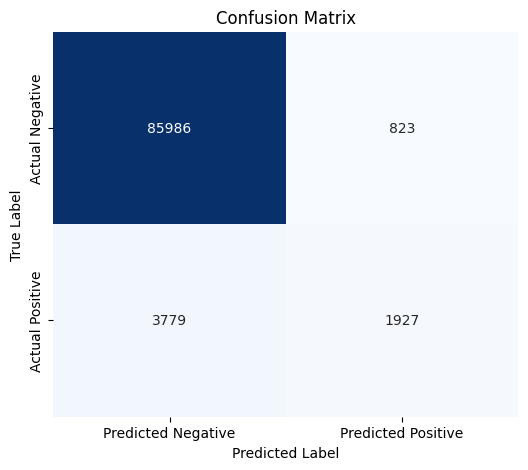

In [73]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(val_df.target, val_pred)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display classification report

In [74]:
# Define class names
class_names = ["sincere", "insincere"]
class_report = classification_report(val_df.target, val_pred, target_names=class_names)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

     sincere       0.96      0.99      0.97     86809
   insincere       0.70      0.34      0.46      5706

    accuracy                           0.95     92515
   macro avg       0.83      0.66      0.71     92515
weighted avg       0.94      0.95      0.94     92515



In [75]:
# Filter the rows where target is 1
target_1_rows = val_df[val_df['target'] == 1]

# Print the filtered rows and their row indices
print("Rows with target = 1:")
print(target_1_rows)

print("\nRow indices of rows with target = 1:")
print(target_1_rows.index.tolist())

Rows with target = 1:
                        qid  \
6      43d79a9f9298612851f6   
21     4fb49f5e2f88ed916eee   
24     6b4b32c17b61b1ea494b   
68     42b187052f769ec13b49   
93     0dcd19fac910b986fd20   
...                     ...   
92460  409507532ffdc96d3893   
92474  1b1f93d0436d7e176317   
92493  39ca0cfeeadd6a1c2b27   
92500  0c2ec5a13246907c7e33   
92507  628e5657fa45fbfc331f   

                                           question_text  target  
6                  Are Irish people inferior than Brits?     1.0  
21     Do people discriminate against the LGBT commun...     1.0  
24     How should America punish the uneducated white...     1.0  
68     Why do so many Asians, especially in the UK ha...     1.0  
93       Why do American Democrats hate America so much?     1.0  
...                                                  ...     ...  
92460  Considering living beings are bits of hardware...     1.0  
92474  Why do leftists proclaim how proud they are of...     1.0  
92

# Applying LIME

In [76]:
# Select a specific instance from the validation set for explanation
prediction_index = 20
idx = int(val_df.index[prediction_index])
# print(idx)
c = make_pipeline(tfidf_vc, model)
class_names = ["sincere", "insincere"]

# Create a LIME text explainer
explainer = LimeTextExplainer(class_names = class_names)

# Explain the prediction for the selected instance
exp = explainer.explain_instance(val_df["question_text"][idx], c.predict_proba, num_features = 10)

# Print the selected question text and its prediction probabilities
print(val_df["question_text"][idx])
print("Probability (Insincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 1])
print("Probability (Sincere) =", c.predict_proba([val_df["question_text"][idx]])[0, 0])
print("True Class is:", class_names[int(val_df["target"][idx])])

Why do you think about the people you love?
Probability (Insincere) = 0.042911936733562
Probability (Sincere) = 0.957088063266438
True Class is: sincere


# Display LIME explanation in a notebook

In [85]:
# Explain the prediction
exp = explainer.explain_instance(val_df["question_text"][idx], 
                                c.predict_proba, 
                                num_features=10)

# Print basic info
print("Question:", val_df["question_text"][idx])
print(f"Predicted: {class_names[c.predict([val_df['question_text'][idx]])[0]]}")
print(f"Actual: {class_names[int(val_df['target'][idx])]}")
print("\nProbabilities:", c.predict_proba([val_df["question_text"][idx]])[0])

# Display options
print("\n1. Show in notebook (interactive):")
exp.show_in_notebook(text=val_df["question_text"][idx], labels=(1,))

print("\n2. Text explanation:")
print(exp.as_list())

print("\n3. Matplotlib figure:")
exp.as_pyplot_figure(label=1).show()

Question: Why do you think about the people you love?


TypeError: list indices must be integers or slices, not numpy.float64

# Extract and plot LIME weights

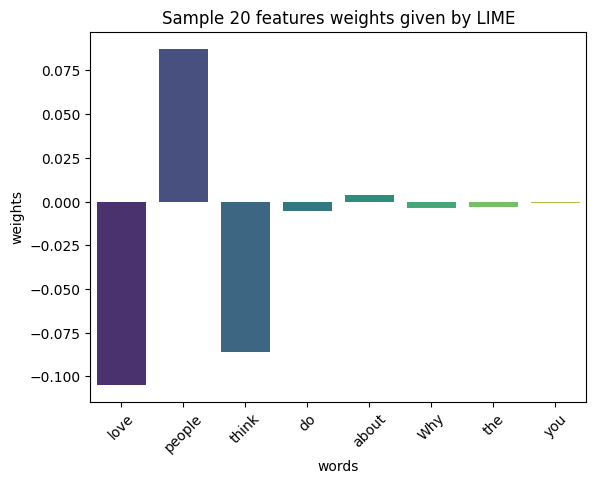

In [83]:
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})
sns.barplot(x = "words", y = "weights", hue='words', data = lime_weights, palette="viridis")
plt.xticks(rotation = 45)
plt.title("Sample {} features weights given by LIME".format(idx))
plt.show()